In [1]:
import os
import pandas as pd
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

In [2]:
node_df = pd.read_csv("processed_data/node_attributes_file.csv")
edges_df = pd.read_csv("processed_data/edge_file.csv")
stations_geo_df = pd.read_csv("processed_data/stations_geo.csv")

# Task 1: Network Resilience

### Construct a network

*   Node: stations
*   Edge: trips between these stations (undirectional)
*   Edge weights: volume of trips

In [3]:
# Construct undirectional network datafile
edges_df_total = edges_df[['start_station_id', 'end_station_id', 'trip_count']].copy()
edges_df_total[['start_station_id', 'end_station_id']] = edges_df_total[['start_station_id', 'end_station_id']].astype(int)

# Sort the station IDs within each row to handle them as undirected edges
edges_df_total['min_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].min(axis=1)
edges_df_total['max_station_id'] = edges_df_total[['start_station_id', 'end_station_id']].max(axis=1)

# Group by the sorted station IDs and sum the trip counts
undirectional_edges_df = edges_df_total.groupby(['min_station_id', 'max_station_id'])['trip_count'].sum().reset_index()

# Remove nodes where min = max
undirectional_edges_df = undirectional_edges_df[undirectional_edges_df.min_station_id != undirectional_edges_df.max_station_id]

In [4]:
# undirectional_edges_df.to_csv("processed_data/total_edge_undirectional.csv", index = False)

In [5]:
# Construct undirectional network
min_nodes = undirectional_edges_df['min_station_id'].tolist()
max_nodes = undirectional_edges_df['max_station_id'].tolist()
weights = undirectional_edges_df['trip_count'].tolist()

g = ig.Graph.TupleList(edges=zip(min_nodes, max_nodes), directed=False, edge_attrs={'weight': weights})

print(f"Network Nodes: {len(g.vs)}, Edges: {len(g.es)}")

Network Nodes: 773, Edges: 81754


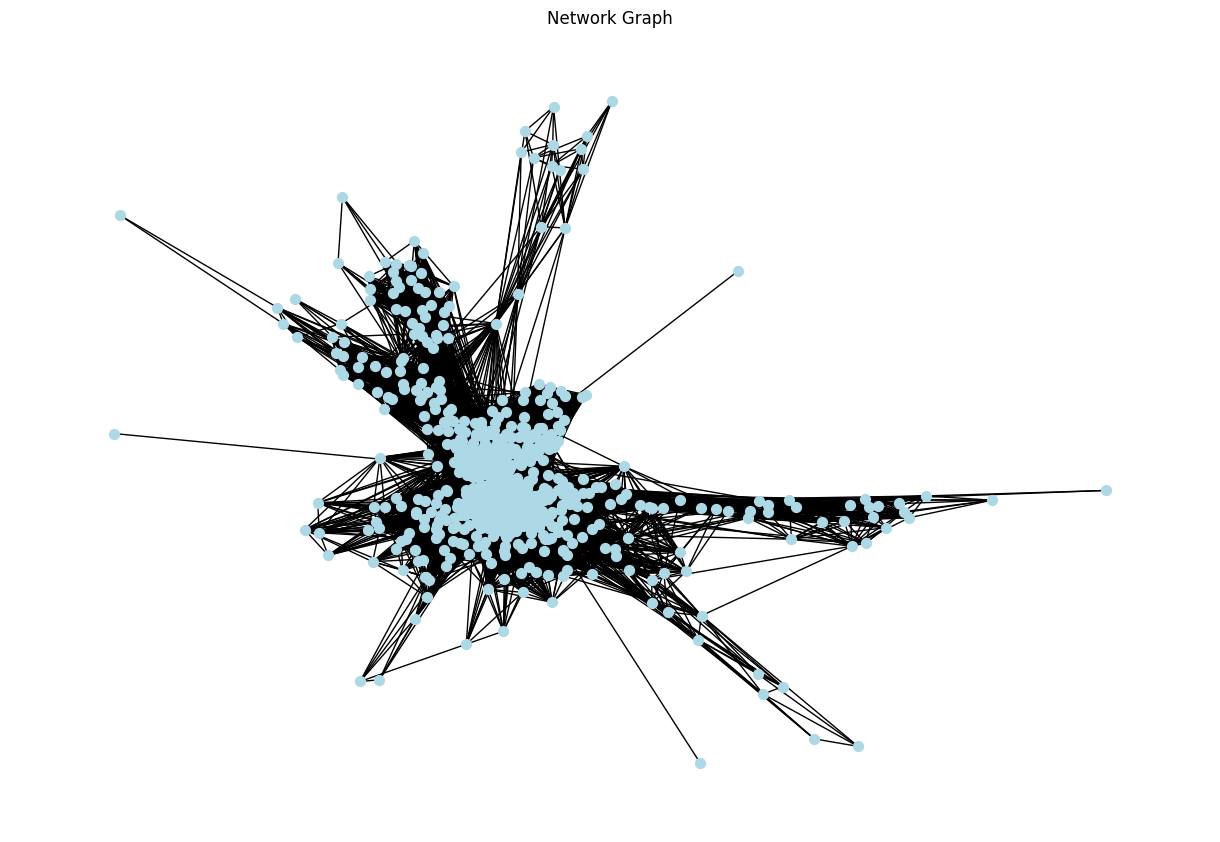

In [6]:
import networkx as nx

network_nx = nx.Graph(g.get_edgelist())
plt.figure(figsize=(12, 8))

nx.draw(network_nx, node_size=50, node_color='lightblue', with_labels=False)
plt.title('Network Graph')
plt.show()

In [22]:
def draw_geographical_network(undirectional_edges_df):
    # Map the nodes based on geo location
    nodes = stations_geo_df.set_index('station_id').to_dict('index')
    G = nx.Graph()
    for node, attrs in nodes.items():
        G.add_node(node, **attrs)

    # Add edges with weights to the graph
    edges = undirectional_edges_df[['min_station_id', 'max_station_id', 'trip_count']]
    G.add_weighted_edges_from(edges.values)

    # Calculate node degrees for sizing (no need to set node attributes)
    degrees = dict(G.degree())
    max_degree = max(degrees.values(), default=1)
    node_sizes = [degrees.get(node, 0) * 200 / max_degree for node in G.nodes()]

    degree_threshold = max_degree * 0.9

    # Normalize edge weights for visualization
    weights = nx.get_edge_attributes(G, 'weight').values()
    max_weight = max(weights, default=1)
    weights_normalized = [weight * 10 / max_weight for weight in weights]

    # Get positions from node attributes
    pos = {node: (data['lng'], data['lat']) for node, data in G.nodes(data=True)}

    # Draw the network with improved visual parameters
    plt.figure(figsize=(15, 12))
    ax = plt.gca()
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='deepskyblue', edgecolors='black', linewidths=0.5)
    nx.draw_networkx_edges(G, pos, width=weights_normalized, alpha=0.7)
    plt.title('Network Graph Based on Geographical Locations')
    plt.axis('off')
    plt.show()

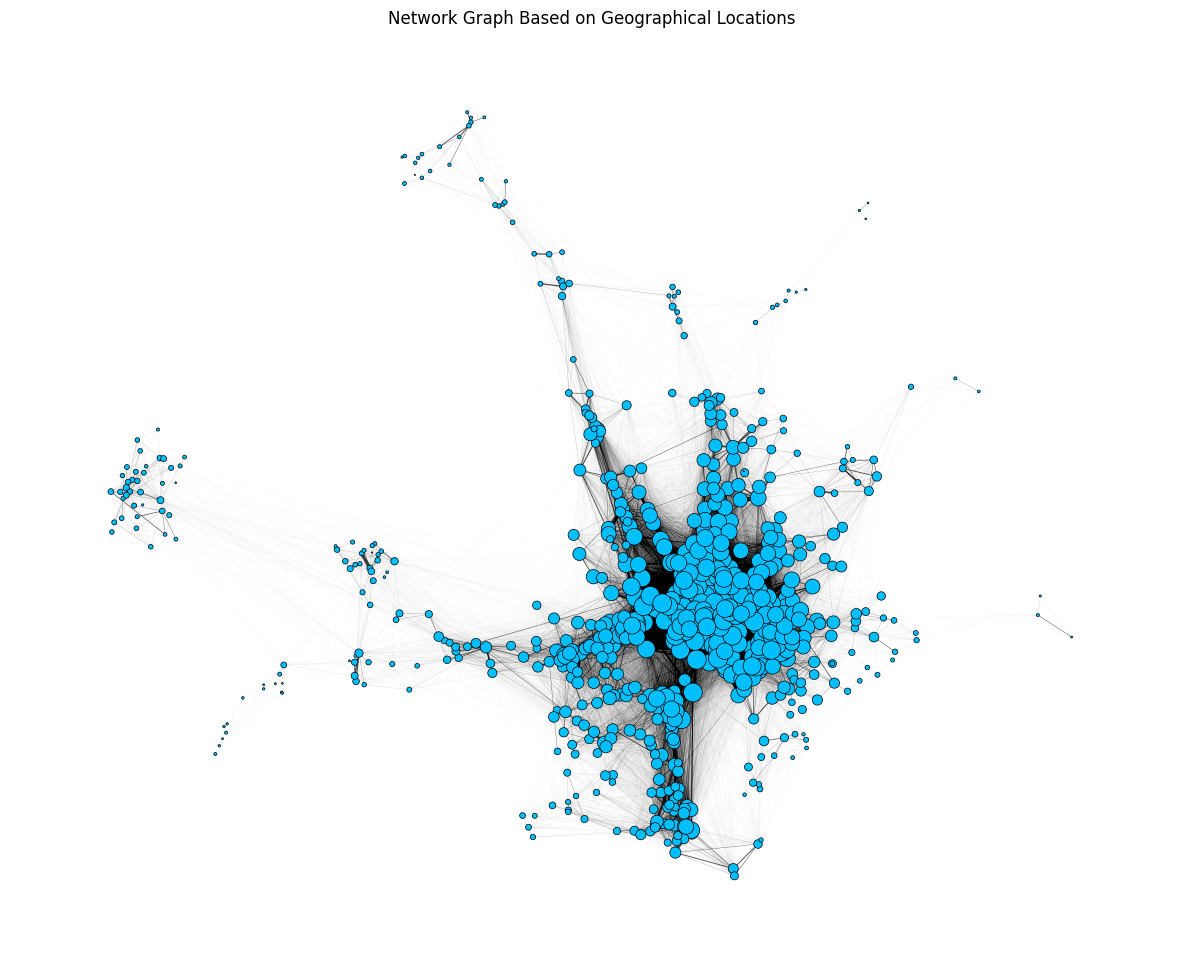

In [23]:
draw_geographical_network(undirectional_edges_df)

### 1.1:
Implement the two types of node deletion strategies on your network, and plot the associated changes in average shortest path length (i.e., average distance) & diameter as a function of the fraction of nodes removed. Do the resulting plots resemble the Fig. 2 on Pg. 12 of the Albert et al. (2000) paper above? Why do you (/don’t you) see this pattern?

### 1.2
Can you think of any other important graph-level metric, apart from average distance or diameter, that can potentially measure structural resilience of the network to such errors and attacks? Compute this metric, and test if this metric also shows significant variation in response to these two types of node deletions.

### 1.3
Repeat the above set of analyses for the network over time (e.g., for each month or quarter or year). Do you see any change in the resilience of the network over time? What patterns (if any) do you see from this temporal analysis?